## ProjF5 - Final Model

Team 160 | Michael Dacanay, Soundarya Khanapur, Ophelia Sin


Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [9]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from sklearn.preprocessing import StandardScaler

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [1]:
# Load the dataset
file_path = 'datasets/train_dataset.csv'  
data = pd.read_csv(file_path)

In [2]:
data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
#ensure no noull values exist
data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [5]:
data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,...,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,...,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,...,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [6]:
#standardize all column names

data.columns = data.columns.str.lower() #convert all columns to lowercase

#strip all symbols and replace with space, strip all tailing whitespaces and remaining white spaces replaced with underscores 
data.columns = data.columns.str.replace(r'[^a-zA-Z0-9]', ' ', regex=True).str.strip()
data.columns = data.columns.str.replace(' ', '_', regex=True)

In [10]:
# create two new features based on existing columns

data['bmi'] = data['weight_kg'] / (data['height_cm']**2)
data['glucose_category'] = pd.cut(data['fasting_blood_sugar'], bins=[0, 99, 125, np.inf], labels=['normal', 'prediabetes', 'diabetes'])


In [11]:
# separate X and y 

X, y = data.drop(['smoking'],axis=1),data['smoking']

In [12]:
# set up preprocess function to convert certain variables to dummies 

def preprocess(df):
    df = pd.get_dummies(df,columns = ["hearing_left", "hearing_right","urine_protein","dental_caries", "glucose_category"],dtype = 'int8')
    return df

In [13]:
X = preprocess(X)

In [24]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Ensure y is also a numpy array
y = y.values

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

#### a. Grid Search
First, we use grid search to identify the hyperparameters that will be most optimal for a simple Sequential model with 3 layers. <br>
- We found that the best model had a 73.1351% accuracy using {'batch_size': 32, 'epochs': 50, 'model__l2_rate': 0.01, 'model__neurons': 64}.

In [18]:
from sklearn.model_selection import  StratifiedKFold, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier 
from tensorflow.keras.regularizers import l2

In [ ]:
def create_model(neurons=128, l2_rate=0.01):
    model = Sequential([
        Dense(neurons, activation='relu', input_dim=X.shape[1], kernel_regularizer=l2(l2_rate)),
        Dense(neurons, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# grid search parameters
param_grid = {
    'model__neurons': [64, 128],
    'model__l2_rate': [0.001, 0.01, 0.02],
    'batch_size': [32, 64],
    'epochs': [20, 50]
}

# Setup cross-validation and grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)

# Perform grid search with cross-validation
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Then, we applied grid search on a more complex model to see if adding more layers is beneficial. We found that the best hyperparameters yielded 72.7042% accuracy using {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001}.


In [19]:
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [25]:
def create_optimized_model(l2_rate, dropout_rate ):
    model = Sequential([
        Input(shape = (X_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(256, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(128, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(64, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(32, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_optimized_model, verbose=0)

# grid search parameters
param_grid = {
    'model__l2_rate': [0.001, 0.01, 0.02],
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'model__dropout_rate': [0.2, 0.3, 0.5],
}

# Setup cross-validation and grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)

# Perform grid search with cross-validation
grid_result = grid.fit(X_scaled, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``

Best: 0.727042 using {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001}
0.703802 (0.034044) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001}
0.668812 (0.035764) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01}
0.661963 (0.036189) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.02}
0.715140 (0.010084) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__l2_rate': 0.001}
0.648753 (0.026487) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__l2_rate': 0.01}
0.662810 (0.027689) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__l2_rate': 0.02}
0.700698 (0.009102) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.001}
0.682640 (0.023786) with: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01}
0.

#### b. Acitvation functions 
We also tested the model with other activation functions such as Stochastic Gradient Descent and RMSprop, to see if the results would improve. We also added **early stopping** to prevent overfitting.

##### i. Stochastic Gradient Descent

The simple model gave us 
- Average accuracy:  0.7321
- Average balanced accuracy:  0.7047

Whereas the complex model gave us 
- Average accuracy:  0.7491
- Average balanced accuracy:  0.7287

In [27]:
# Simple model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import balanced_accuracy_score


from sklearn.utils import class_weight
import numpy as np

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_model(neurons=64, l2_rate=0.01):
    model = Sequential([
        Dense(neurons, activation='relu', input_dim=X.shape[1], kernel_regularizer=l2(l2_rate)),
        Dense(neurons, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Assuming you have a setup for training and validation splits
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]

accuracies = [] 
balanced_accuracies = []

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):
    model = create_model()
    # Fit data to model
    history = model.fit(X_scaled[train], y[train], epochs=50, batch_size=32, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    balanced_accuracies.append(balanced_accuracy)

    print("Balanced Accuracy:", balanced_accuracy)

print("Average accuracy: ", np.mean(accuracies))
print("Average balanced accuracy: ", np.mean(balanced_accuracies))

/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 25: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
Balanced Accuracy: 0.7184402983215308


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Balanced Accuracy: 0.7282362639820523


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
Balanced Accuracy: 0.6965592784088914


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Balanced Accuracy: 0.7235671180929519


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
Balanced Accuracy: 0.6566552048940256
Average accuracy:  0.7321462154388427
Average balanced accuracy:  0.7046916327398904


In [28]:
# Complex model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score


from sklearn.utils import class_weight
import numpy as np

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_optimized_model(l2_rate = 0.001, dropout_rate= 0.2):
    model = Sequential([
        Input(shape = (X_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(256, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(128, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(64, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(32, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Assuming you have a setup for training and validation splits
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]

accuracies = [] 
balanced_accuracies = []

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):
    model = create_optimized_model()
    # Fit data to model
    history = model.fit(X_scaled[train], y[train], epochs=20, batch_size=64, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    balanced_accuracies.append(balanced_accuracy)
    print("Balanced Accuracy:", balanced_accuracy)

print("Complex model results with SGD")
print("------------------------------")
print("Average accuracy: ", np.mean(accuracies))
print("Average balanced accuracy: ", np.mean(balanced_accuracies))

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Balanced Accuracy: 0.7100741769317798
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7337254970798646
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7365076097924479
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7186369331196948
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.744424891874556
Complex model results with SGD
------------------------------
Average accuracy:  0.749051034450531
Average balanced accuracy:  0.7286738217596687


##### ii. RMSProp 
Here we chose to use a learning rate of 0.001 for testing.

The simple model yields:
- Average accuracy:  0.7481
- Average balanced accuracy:  0.7255

And the complex model yielded:
- Average accuracy:  0.7444
- Average balanced accuracy:  0.7253

In [30]:
# Simple model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score


from sklearn.utils import class_weight
import numpy as np

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_model(neurons=64, l2_rate=0.01):
    model = Sequential([
        Dense(neurons, activation='relu', input_dim=X.shape[1], kernel_regularizer=l2(l2_rate)),
        Dense(neurons, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]

accuracies = [] 
balanced_accuracies = []

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):
    model = create_model()
    # Fit data to model
    history = model.fit(X_scaled[train], y[train], epochs=50, batch_size=32, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    balanced_accuracies.append(balanced_accuracy)

    print("Balanced Accuracy:", balanced_accuracy)

print("Simple model results with RMSProp")
print("------------------------------")
print("Average accuracy: ", np.mean(accuracies))
print("Average balanced accuracy: ", np.mean(balanced_accuracies))

/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 32: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Balanced Accuracy: 0.7373228284147237


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
Balanced Accuracy: 0.7132804439828904


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Balanced Accuracy: 0.7223485346095784


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
Balanced Accuracy: 0.7213491932134989


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
Balanced Accuracy: 0.7330112080290139
Simple model results with RMSProp
------------------------------
Average accuracy:  0.7481019020080566
Average balanced accuracy:  0.7254624416499411


In [31]:
# Complex model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_optimized_model(l2_rate = 0.001, dropout_rate= 0.2):
    model = Sequential([
        Input(shape = (X_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(256, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(128, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(64, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(32, kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')
    ])
    
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Assuming you have a setup for training and validation splits
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]

accuracies = [] 
balanced_accuracies = []

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):
    model = create_optimized_model()
    # Fit data to model
    history = model.fit(X_scaled[train], y[train], epochs=20, batch_size=64, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    balanced_accuracies.append(balanced_accuracy)
    print("Balanced Accuracy:", balanced_accuracy)

print("Complex model results with RMSProp")
print("------------------------------")
print("Average accuracy: ", np.mean(accuracies))
print("Average balanced accuracy: ", np.mean(balanced_accuracies))

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7302717801217884
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7237733180484412
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7231214970549498
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.715346591777088
Epoch 10: early stopping
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.733826428171731
Complex model results with RMSProp
------------------------------
Average accuracy:  0.7444080829620361
Average balanced accuracy:  0.7252679230347996


In [11]:
from sklearn.metrics import confusion_matrix
import itertools

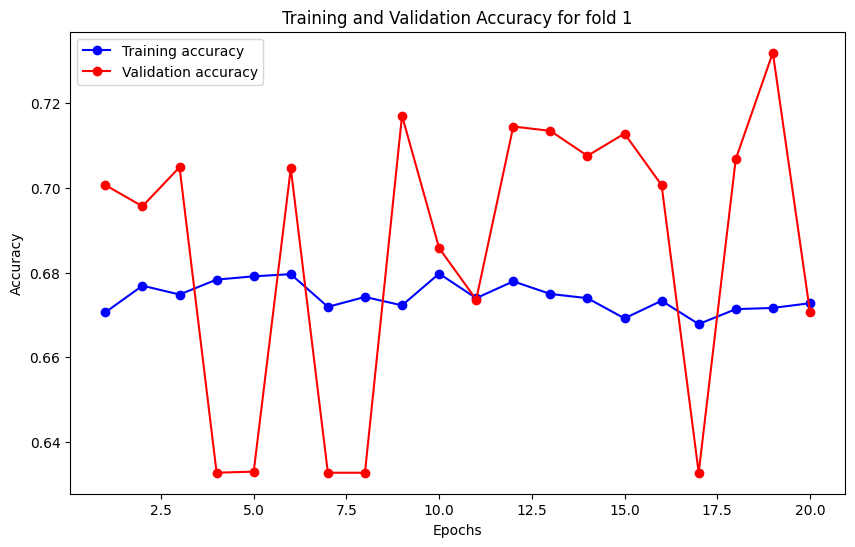

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.5694240320291912


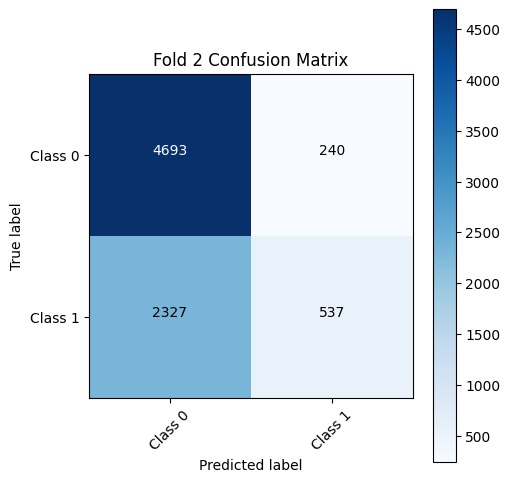

Epoch 10: early stopping


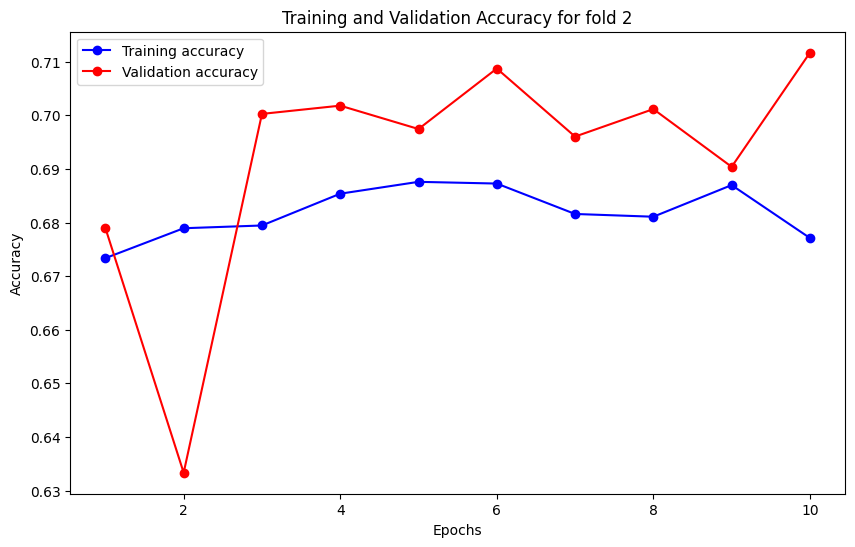

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7047085626161513


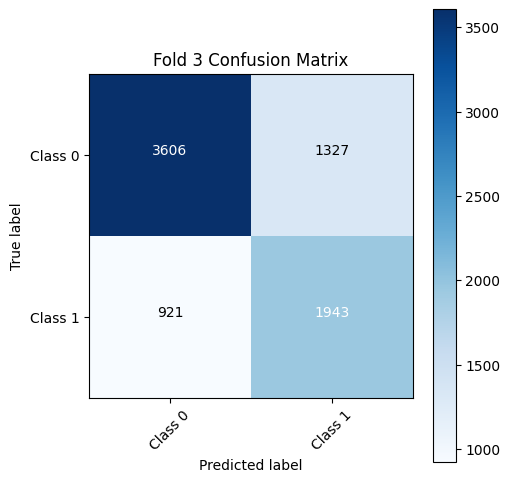

Epoch 10: early stopping


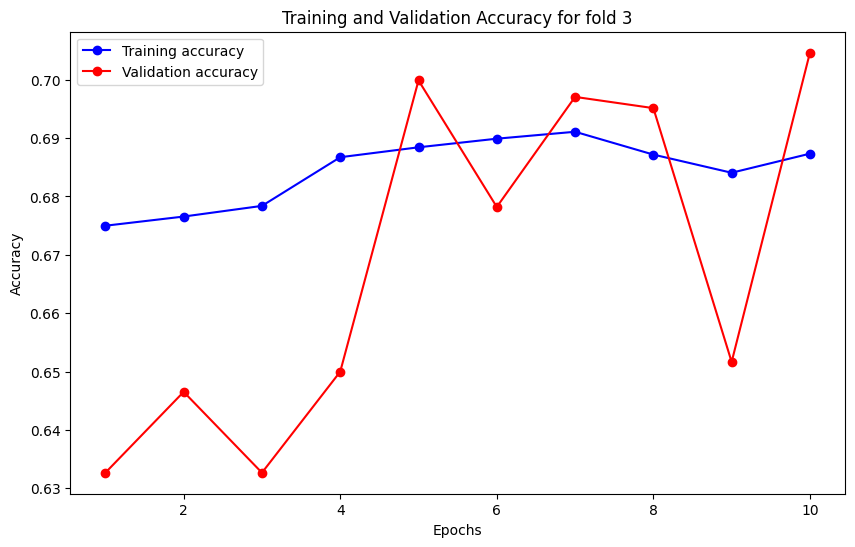

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.6992803072342575


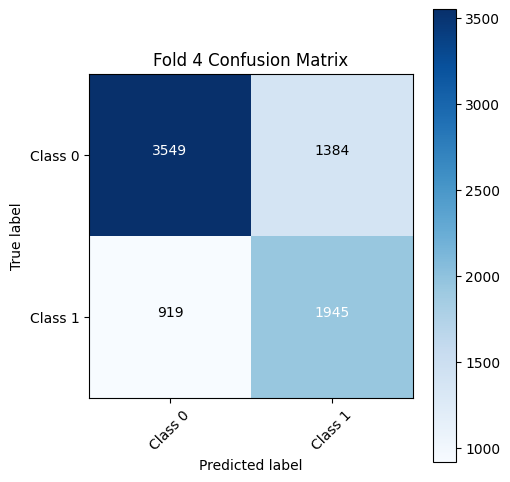

Epoch 10: early stopping


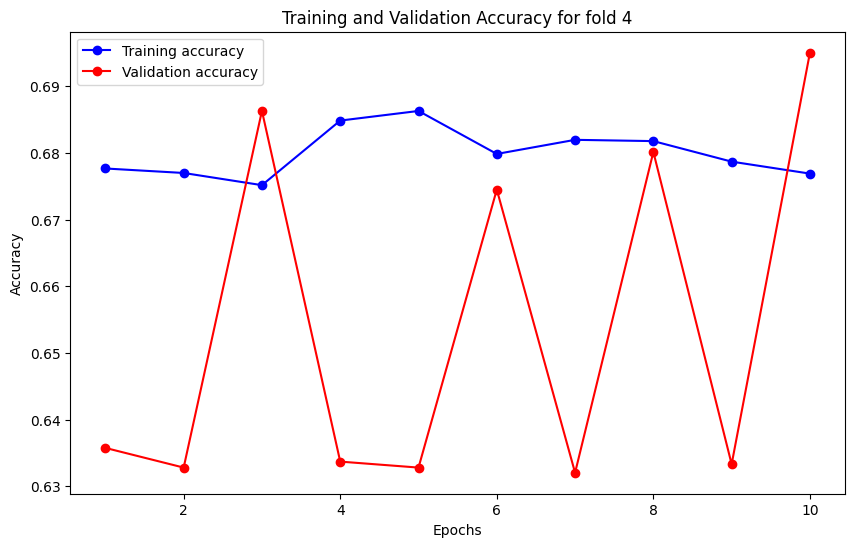

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.7324095808295062


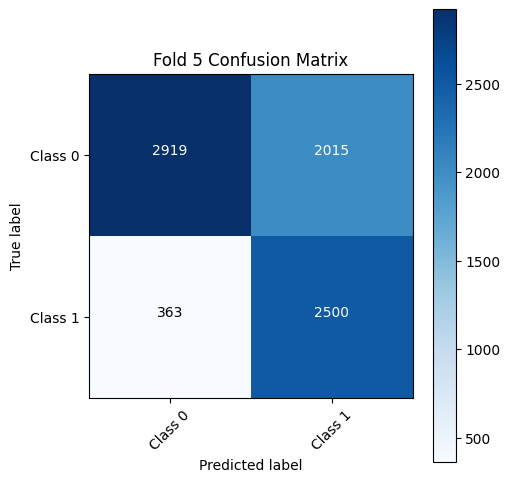

Epoch 10: early stopping


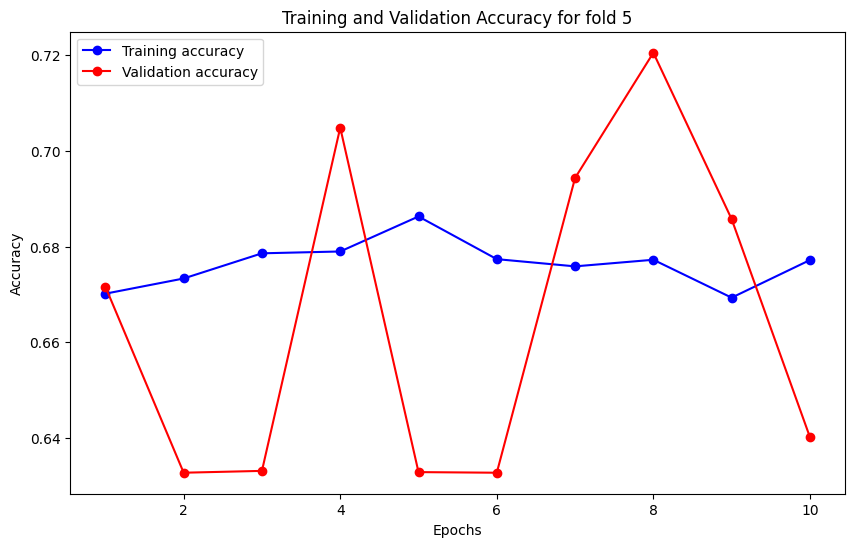

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanced Accuracy: 0.5146728296794936


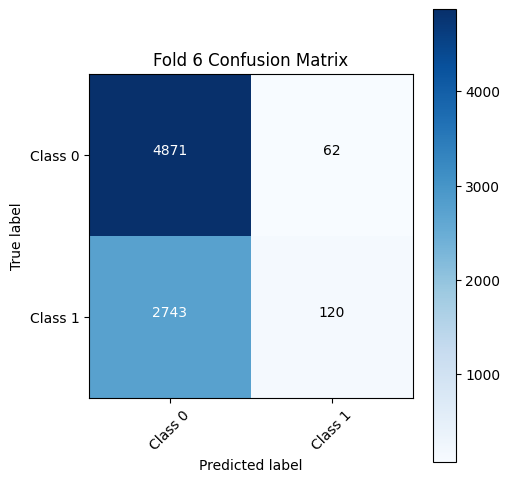

nan nan nan
Average accuracy: 0.68, with standard deviation: 0.03


/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/opheliasin/smokerstatusNNDL/myenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Function to create the model, now just returning the model instance
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall
from tensorflow.keras.initializers import HeNormal, HeUniform
from sklearn.metrics import balanced_accuracy_score


from sklearn.utils import class_weight
import numpy as np

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

class_weights = dict(enumerate(class_weights))

def create_optimized_model():
    model = Sequential([
        Input(shape = (X_scaled.shape[1],)),
        Dense(512, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(64, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),

        Dense(32, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        # Dense(32, kernel_regularizer=l2(0.01)),
        # BatchNormalization(),
        # Activation('relu'),


        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Assuming you have a setup for training and validation splits
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]
# List to store each fold's accuracy
accuracies = []
aucs = []
precisions = []
recalls = []
fold_no = 1
 
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):
    model = create_optimized_model()
    # Fit data to model
    history = model.fit(X_scaled[train], y[train], epochs=20, batch_size=32, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy for fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    fold_no += 1

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    print("Balanced Accuracy:", balanced_accuracy)


    ### Confusion matrix
    cm = confusion_matrix(y[test], y_pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Fold {fold_no} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)  # Assuming binary classification
    plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# Print out the average and the standard deviation of the accuracies
average_accuracy = np.mean(accuracies)
std_deviation_accuracy = np.std(accuracies)
average_auc = np.mean(aucs)
average_precisions = np.mean(precisions)
average_recall = np.mean(recalls)

print(average_auc, average_precisions, average_recall)
print(f'Average accuracy: {average_accuracy:.2f}, with standard deviation: {std_deviation_accuracy:.2f}')

- 0.78 accuracy - neurons = 64, epochs = 20
- 0.79 accuracy - neurons = 64, epochs = 50
- 0.79 accuracy - neurons = 24, epochs = 20
- 0.78 accuracy - neurons = 24, epochs = 50

- Dropout 0.4, 0.3 - 0.8 accuracy

### SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

Mean: [-0.04408489  0.11316279  0.0854681   0.06285705  0.015974    0.0183819
  0.02221759  0.03058233  0.0238526  -0.00330247  0.06369166 -0.05259766
 -0.00498399  0.11223589  0.06048217  0.0093526   0.02168052  0.05717655
  0.03029164  0.00547845 -0.00547845  0.00097946 -0.00097946  0.00192039
 -0.00611452  0.00166566  0.00566586  0.00150077 -0.00237582 -0.03033755
  0.03033755 -0.02221455  0.0165265   0.01302749]
Standard Deviation: [0.97706828 0.96274997 0.98826024 0.98299186 0.98152957 0.96857519
 0.97339927 0.97874091 1.01629729 0.98567287 1.00853498 0.97235054
 1.00898836 0.95965988 0.95493761 1.02364438 1.01761441 1.023803
 0.99149182 0.98244907 0.98244907 0.99661442 0.99661442 0.99592676
 0.98350299 1.00538823 1.03968542 1.0192248  0.88896053 1.01956405
 1.01956405 1.00573151 1.00651723 1.02293928]


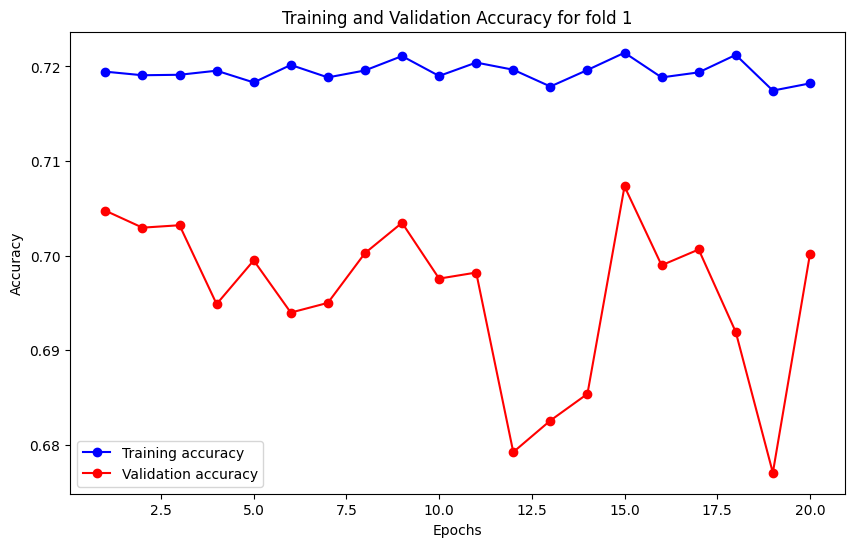

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
Balanced Accuracy: 0.7424489202803601


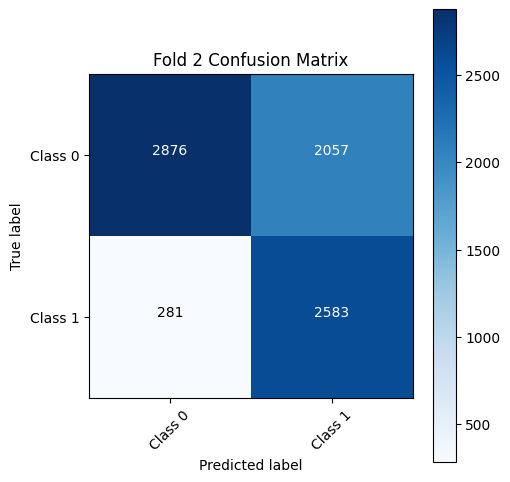

Mean: [-0.04574807  0.10390339  0.07611799  0.05552541  0.02256774  0.02194093
  0.01030762  0.02374638  0.02418227 -0.00515896  0.06382483 -0.05549514
 -0.0076741   0.10711601  0.05632783  0.00566365  0.01896948  0.05293972
  0.02433465  0.00681169 -0.00681169  0.01016241 -0.01016241 -0.00100676
  0.0003193   0.00071277  0.00334129 -0.00310103 -0.00237582 -0.0295805
  0.0295805  -0.02702721  0.02292915  0.0103953 ]
Standard Deviation: [0.97653728 0.96093773 0.98896244 0.97998751 0.99019498 0.97869947
 0.972328   0.97786977 1.0176833  0.9837449  1.01151614 0.97680802
 0.96599131 0.95830669 0.94368483 0.94934248 0.9572152  1.03710875
 0.99025526 0.97891358 0.97891358 0.96905942 0.96905942 1.00137259
 1.00047344 1.00187676 1.02273165 0.95904838 0.88896053 1.01908877
 1.01908877 1.00711309 1.00917916 1.01829429]
Epoch 10: early stopping


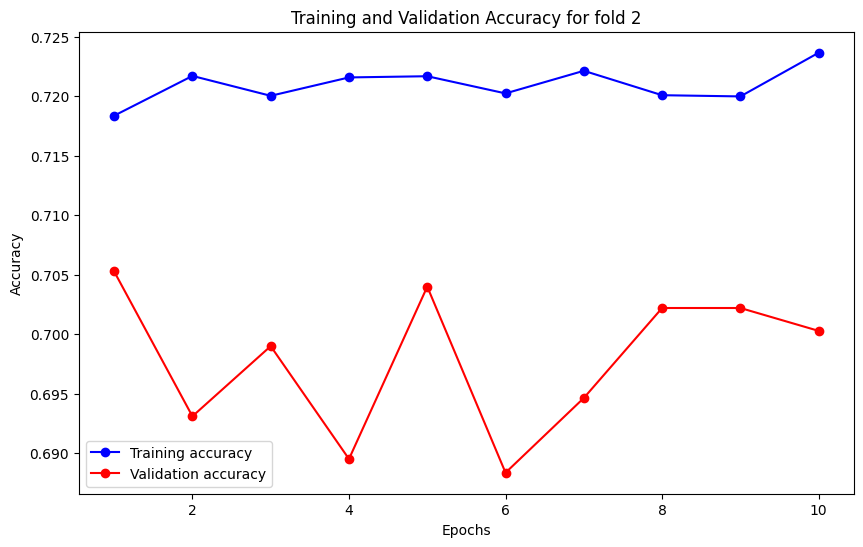

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
Balanced Accuracy: 0.7325187540982121


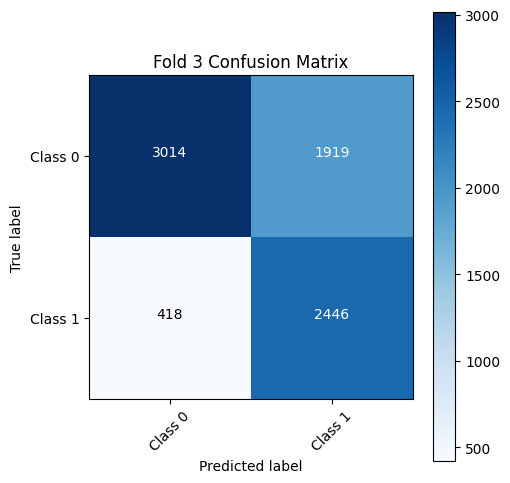

Mean: [-0.05303475  0.11583427  0.08660181  0.06206733  0.0147396   0.01648533
  0.0156448   0.0298727   0.02939845 -0.01180071  0.06659091 -0.04869105
 -0.01765006  0.11550474  0.05802133  0.01135417  0.02021456  0.05901532
  0.02903096  0.00812047 -0.00812047  0.00685693 -0.00685693 -0.00266274
 -0.00099737  0.00427992  0.00399575 -0.00112883 -0.00013832 -0.0283415
  0.0283415  -0.02254289  0.0125304   0.02141532]
Standard Deviation: [0.98076934 0.96741862 0.98978067 0.98206307 0.96422518 0.97719524
 0.96932305 0.97548189 1.04151268 0.98582854 1.02084272 0.97651753
 0.93779418 0.96054633 0.93457362 1.03491374 0.9080478  1.06971644
 0.98676    0.97464292 0.97464292 0.97911897 0.97911897 1.00486724
 0.99720369 1.01508723 1.0286173  0.98529105 0.9938755  1.01828883
 1.01828883 1.00593958 1.0048879  1.03810569]
Epoch 10: early stopping


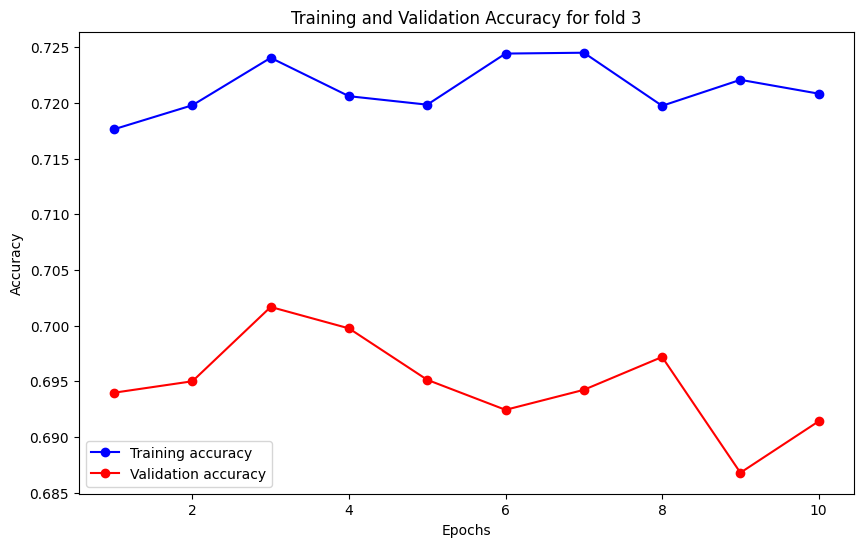

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
Balanced Accuracy: 0.7294790698148486


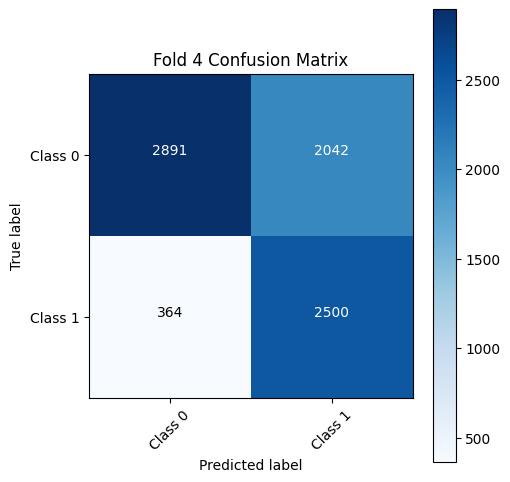

Mean: [-0.0535614   0.11436034  0.0852126   0.06186118  0.01558266  0.01861574
  0.01719977  0.02912336  0.02257469 -0.01311814  0.06401275 -0.05732376
 -0.00974186  0.11756631  0.06639884  0.00421807  0.01875696  0.05363123
  0.0281849   0.00637367 -0.00637367  0.00518316 -0.00518316 -0.00750041
  0.00372835  0.00330365  0.00487353  0.00873456 -0.00345701 -0.02571771
  0.02571771 -0.02348025  0.01593265  0.01673731]
Standard Deviation: [0.98234851 0.96488413 0.98921782 0.98150626 0.94593522 0.95157165
 0.97086482 0.97336768 1.02580236 0.98136726 1.01350795 0.97614865
 1.04808742 0.95009055 0.97975774 0.9338406  0.98013799 1.05702769
 0.98618523 0.98025295 0.98025295 0.98409267 0.98409267 1.01404859
 1.00944304 1.01171216 1.03419501 1.10718877 0.80339941 1.01648942
 1.01648942 1.00597909 1.00613876 1.0298567 ]
Epoch 10: early stopping


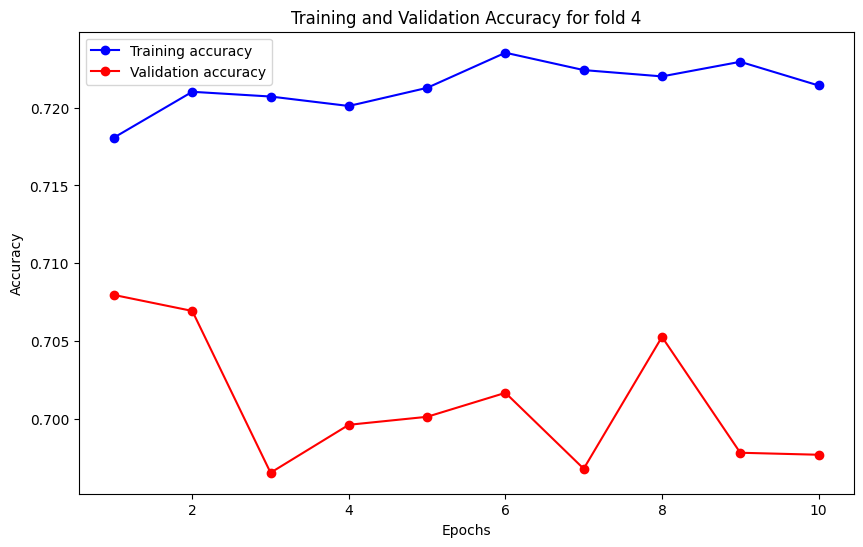

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Balanced Accuracy: 0.7344643673011875


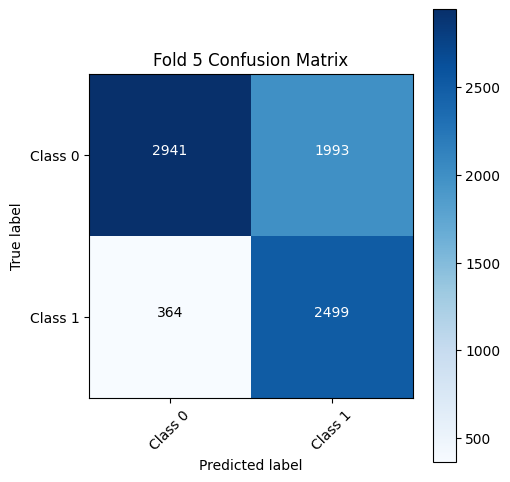

Mean: [-0.05288266  0.11332169  0.08079567  0.05819696  0.02197616  0.01806476
  0.00728455  0.02114266  0.02905636 -0.01097589  0.06061799 -0.05116783
 -0.00812741  0.11059553  0.05319216  0.0032844   0.01705262  0.05284274
  0.02398863  0.00317815 -0.00317815  0.0089569  -0.0089569  -0.00610147
  0.00362267  0.00135267  0.00734111  0.00281557 -0.00237582 -0.02532473
  0.02532473 -0.02482671  0.01473893  0.02176998]
Standard Deviation: [0.97887643 0.96282595 0.98635721 0.9790521  0.9915421  0.93475078
 0.9703004  0.98056011 1.04714326 0.98424235 1.01317817 0.97692184
 1.04257998 0.96059496 0.93250792 0.91201666 0.91389011 1.02591781
 0.98927856 0.99012683 0.99012683 0.97260675 0.97260675 1.01138804
 1.00924307 1.00442143 1.05196631 1.03577237 0.88896053 1.01655405
 1.01655405 1.00628965 1.00571502 1.0388293 ]
Epoch 10: early stopping


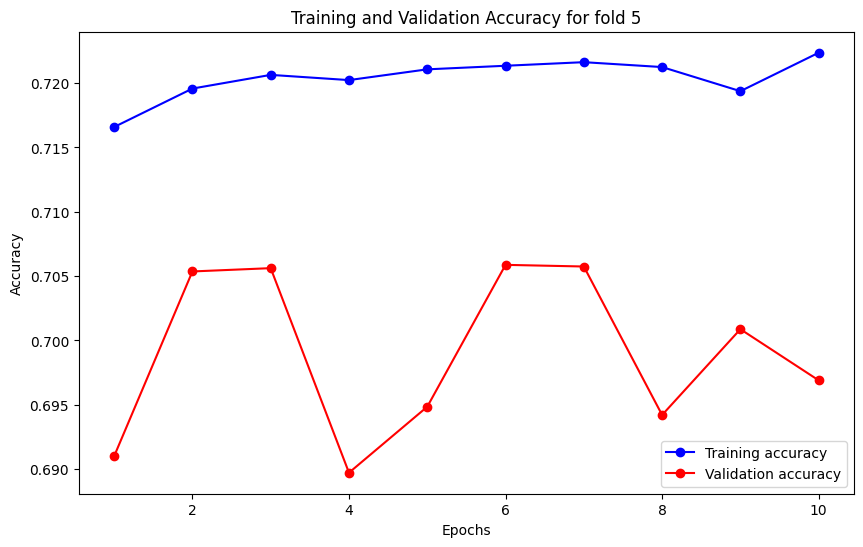

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
Balanced Accuracy: 0.7363802087334587


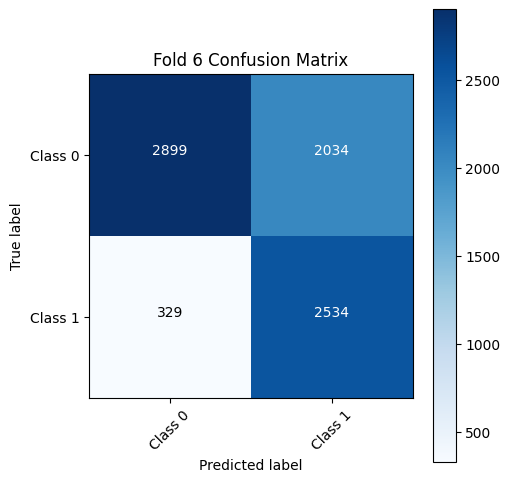

Average accuracy: 0.70, with standard deviation: 0.00


In [15]:
# Function to create the model, now just returning the model instance
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score

# Define the K-fold cross validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate class weights
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

# class_weights = dict(enumerate(class_weights))

def create_optimized_model(neurons = 64):
    model = Sequential([
        Input(shape = (X_scaled.shape[1],)),
        Dense(neurons, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(neurons, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(64, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming you have a setup for training and validation splits
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
]
# List to store each fold's accuracy
accuracies = []

fold_no = 1

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_scaled, y):

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_scaled[train], y[train])
    
    print("Mean:", np.mean(X_train_smote, axis=0))
    print("Standard Deviation:", np.std(X_train_smote, axis=0))

    model = create_optimized_model()
    # Fit data to model
    history = model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, callbacks=callbacks, verbose=0, validation_split=0.2, 
                        validation_data=(X_scaled[test], y[test]))
    # Evaluate the model
    _, accuracy = model.evaluate(X_scaled[test], y[test], verbose=0)
    accuracies.append(accuracy)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy for fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    fold_no += 1

    y_pred = model.predict(X_scaled[test]) 
    y_pred_labels = (y_pred > 0.5).astype(int)
    balanced_accuracy = balanced_accuracy_score(y[test], y_pred_labels)

    print("Balanced Accuracy:", balanced_accuracy)

    ### Confusion matrix
    cm = confusion_matrix(y[test], y_pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Fold {fold_no} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)  # Assuming binary classification
    plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# Print out the average and the standard deviation of the accuracies
average_accuracy = np.mean(accuracies)
std_deviation_accuracy = np.std(accuracies)
print(f'Average accuracy: {average_accuracy:.2f}, with standard deviation: {std_deviation_accuracy:.2f}')

#Average accuracy: 0.70, with standard deviation: 0.01

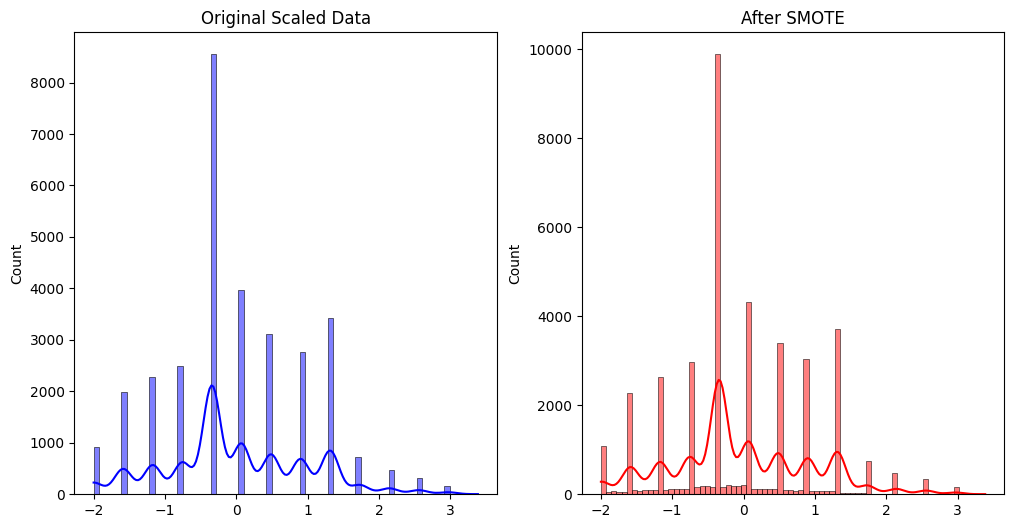

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compare distributions before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(X_scaled[train][:, 0], ax=ax[0], color='blue', kde=True)  # Just example for 1st feature
ax[0].set_title('Original Scaled Data')
sns.histplot(X_train_scaled[:, 0], ax=ax[1], color='red', kde=True)
ax[1].set_title('After SMOTE')
plt.show()


3. Model Performance
Make sure to include the following:

Performance on the training set
Performance on the test set
Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.